### Import Various Necessary Libraries Dask and Related Libraries

In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask
import os
import sys
import uuid

### Add proxy binaries to path

In [2]:
pwd = !echo ${PWD}

### Extend the local python paths with some network drives

In [3]:
extension_python_paths = ['/datasets/work/oa-roamsurf/work/cmextremes_py/extraction/', os.environ["HOME"] + '/lib/python3.8/site-packages']
[sys.path.append(an_ext) for an_ext in extension_python_paths]

[None, None]

### Specify a python exe used by SLURM to create the dask workers


In [4]:
containered_python_exe = f"srun --export=ALL -n $SLURM_NTASKS -c $SLURM_CPUS_PER_TASK   singularity run {os.environ['SINGULARITY_CONTAINER']} python"

### If you run this cell after creating a cluster it will close that cluster 

In [5]:
try:
    cluster.close()
except:
    pass

### Create a cluster
env_extra sets the worker specific environment parameters   

PYTHONPATH is set to include the extension ptyhon paths and the SINGULARITY_BINDPATH bind paths of this jupyter environment for passing to the workers

In [6]:
job_suffix = os.environ['JOB_SUFFIX'] if 'JOB_SUFFIX' in os.environ.keys() else str(uuid.uuid4())[:8]

## List available project codes

In [7]:
!get_project_codes

/bin/bash: get_project_codes: command not found


In [8]:
# defined = 'NC_IN_GLOB' in os.environ.keys()
# if not defined:
#     print("WARNING, project code note defined defaulting")
#     project_code = 'OD-215204'
# else:
#     project_code = os.environ['NC_IN_GLOB']

# OD-229130	2023-12-31	Van KIRAP 2.0: GCF Vanuatu Climate Information Services for Resilient Development
project_code = 'OD-229130'

In [9]:
job_extra = f'--account {project_code}'

In [10]:
process_number = 2

In [11]:
cluster = SLURMCluster(
    cores=4, memory="32G", processes=process_number,
    walltime="01:30:00",
    interface='ib0',
    death_timeout=480,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    env_extra=[
              'module load singularity', # ensure singularity is loaded
              'export PYTHONPATH=' + ':'.join(extension_python_paths),
              'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'], 
              'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    extra = [f'--local-directory={os.environ["SCRATCH2DIR"]}'],
    python=containered_python_exe,  # use pyhton in container
)

# Debug by running cluster.job_script()

## if running a single process based cluster something like this might be needed
```
cluster = SLURMCluster(
    cores=1, memory="24G", processes=1,
    walltime="01:59:00",
    interface='ib0',
    death_timeout=480,
    nanny=False,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    extra = [f' --local-directory={os.environ["SCRATCH2DIR"]}'],
    env_extra=[
    'module load singularity', # ensure singularity is loaded
    'export PYTHONPATH=' + ':'.join(extension_python_paths),
    'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'],
    'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    python=containered_python_exe, # use pyhton in container    
)
```

### Create a client, this will inject dask into xarray and the distributed cluster into dask

In [12]:
client = Client(cluster, timeout=240)
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.149.202.155:8787/status,
Dashboard: http://10.149.202.155:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.149.202.155:45829,Workers: 0
Dashboard: http://10.149.202.155:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
port = client.dashboard_link.split('/')[-2].split(':')[-1]
print(f"Try http://localhost:8888/proxy/{port}/status for the dask dashboard")

Try http://localhost:8888/proxy/8787/status for the dask dashboard


### Scale your workers

With the default config in SLURMCluster above each job will get create 2 workers, one per process and each will have 30gb ram and 4 cores

In [14]:
max_workers = 4

import time
for i in range(0, max_workers): 
    cluster.scale(jobs=i) #yes this looks weird requesting n+1 workers everytime but really it only requests 1 new worker each time
    time.sleep(5)

timeout = 600   # seconds till timeout, timeout if cluster not up in 10 minutes
timeout_start = time.time()
while len(client.ncores().keys())*process_number < max_workers -1:
    if (time.time() > timeout_start+timeout):
        raise Exception(f"Failed to start enough workers in {timeout} seconds, {len(cluster.workers)} started")
    time.sleep(1)

In [15]:
len(client.ncores())

4

## Actual original notebook cells to do the work ...

In [16]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import glob

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


In [17]:
# # # only run this if above dask cluster cells are notrun
# # # comment out otherwise
# from dask.distributed import Client, LocalCluster 
# cluster = LocalCluster() # Launches a scheduler and workers locally 
# client = Client(cluster)

In [18]:
# get some pre-defined functions
# probably want to move them somewhere better more accessible
base_path = '/datasets/work/oa-vankirap/work/'
sys.path.append(f'{base_path}/schism/bin/')
from SCHISM_load_plot_defs import schism_meshtri, schism_plot

In [19]:
# only look at last year, so we don't have too much data
# files = glob.glob(f'{base_path}/schism/Hindcast_v2/schout_*_elev_hs.nc')
schout_ds = xr.open_dataset(f'{base_path}/schism/Hindcast_v2/schout_2015_elev_hs.nc', chunks='auto')

# schout_ds = xr.open_mfdataset(f'{base_path}/schism/bathy_changes/coastal_bathy3/schout_*.nc', chunks='auto')
# schout_ds

In [20]:
# for var in ['SCHISM_hgrid_face_nodes','SCHISM_hgrid_node_x','SCHISM_hgrid_node_y','depth']:
#     schout_ds[var]=schout_ds[var].isel(time=0)

In [21]:
meshtri = schism_meshtri(schout_ds)
# need this for masking, etc.
schout_ds['minimum_depth']=np.asarray([0.05])

In [22]:
schout_ds['elev_var'] = schout_ds.elev.var(dim='time')

(<Figure size 720x720 with 2 Axes>, <GeoAxesSubplot:>)

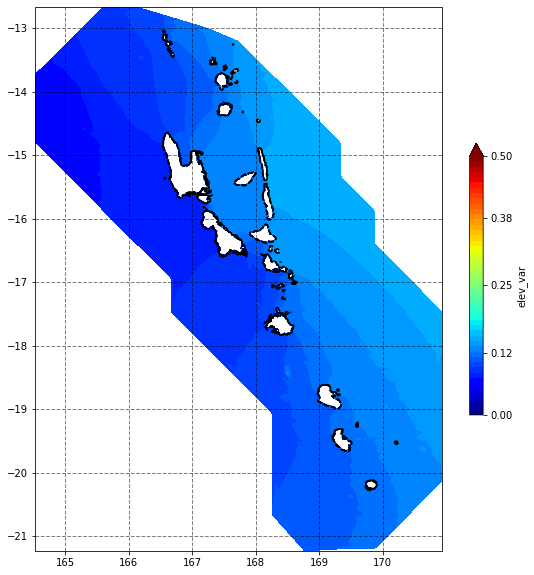

In [23]:
schism_plot(schout_ds, meshtri,'elev_var', varscale=[0,0.5], pscale=10,project=True)

In [24]:
# Potential problem areas:
plot_regions = {
    'Erakor Lagoon, Efate': [168.24,-17.82,168.38,-17.695],
    'Moso/Undine, Efate': [168.18,-17.63,168.44,-17.4],
    'Port Resolution, Tanna': [169.48,-19.54,169.515,-19.505],
    'Aore/Luganville, Santo': [167.1,-15.65,167.27,-15.4],
    'Lonnoc, Santo': [167.05,-15.16,167.2,-15.08]}
    # 'East Malekula:

test_locations = {
    'Erakor Lagoon, Efate': [[168.3,-17.78],[168.322,-17.75],[168.35,-17.752]],
    'Moso/Undine, Efate': [],
    'Port Resolution, Tanna': [[169.50,-19.52],[169.495,-19.526]],
    'Aore/Luganville, Santo': [],
    'Lonnoc, Santo': []}
    # 'East Malekula:

In [25]:
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs

EOMap_shoreline_file = f'{base_path}/GIS_layers/EOMAP/Shoreline/SLP_VUT_Vanuatu_EOMAP_2021_polygon.shp'

shoreline_feature = ShapelyFeature(Reader(EOMap_shoreline_file).geometries(),ccrs.PlateCarree(),
                               linewidth = 1, facecolor = 'None', 
                               edgecolor = (1, 0.2, 0.2, 1))

EOMap_bathy_ds = xr.open_dataset(f'{base_path}/GIS_layers/MERGE_MSB_VUT_Vanuatu_EOMAP_2021_50m_MSL_geotiff_egm96_3arcsec_allLiDAR_GDAL_nogap_wgs84.tif',engine='rasterio')

In [26]:
# EOMap_bathy_ds

In [27]:
from scipy.spatial import cKDTree
def kdtree_find2Didx(x,y,points):
    combined_x_y_arrays = np.dstack([x.ravel(),y.ravel()])[0]
    mytree = cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points)
    indexes=np.unravel_index(indexes, x.shape)[0]
    return indexes

In [28]:
x = schout_ds.SCHISM_hgrid_node_x.values
y = schout_ds.SCHISM_hgrid_node_y.values

In [29]:
import matplotlib.pyplot as plt

In [30]:
test_locs=test_locations['Erakor Lagoon, Efate']

idxs = kdtree_find2Didx(x,y,test_locs)

# fig, axs = plt.subplots(nrows=len(test_locs))
# for aix,loc in enumerate(test_locs):
#     idx = kdtree_find2Didx(x,y,loc)
#     schout_ds.isel(nSCHISM_hgrid_node=idx[0]).elev.plot(ax=axs[aix])

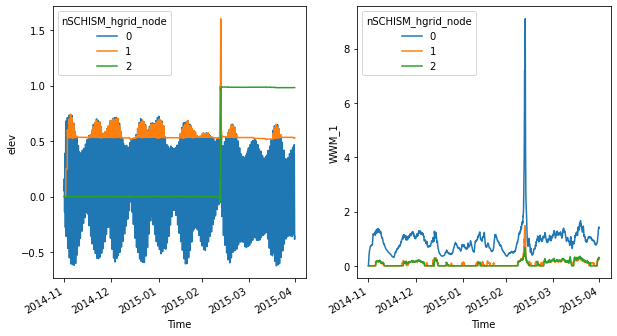

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
schout_ds.isel(nSCHISM_hgrid_node=idxs).elev.plot.line(x='time',ax=axs[0])
# schout_ds.isel(nSCHISM_hgrid_node=idxs).hs.plot.line(x='time',ax=axs[1])
schout_ds.isel(nSCHISM_hgrid_node=idxs).WWM_1.plot.line(x='time',ax=axs[1])

In [ ]:
# for key, bbox in plot_regions.items():
#     fig, ax = schism_plot(schout_ds, meshtri,'elev_var', varscale=[0,0.5], 
#                           bbox = bbox, pscale=20,project=True,plotmesh=True,
#                           contours=[0,1,5])
#     # depth_data = EOMap_bathy_ds.isel(x=slice(
    
#     ax.set_title(key)
#     ax.add_feature(shoreline_feature)
#     test_locs=test_locations[key]
#     if len(test_locs)>0:
#         idxs = kdtree_find2Didx(x,y,test_locs)
#         pdata = schout_ds.isel(nSCHISM_hgrid_node=idxs)
#         ax.plot(pdata.SCHISM_hgrid_node_x,pdata.SCHISM_hgrid_node_y, 'ro')
#         for idx,ival in enumerate(idxs):
#             ax.text(pdata.SCHISM_hgrid_node_x[idx],pdata.SCHISM_hgrid_node_y[idx], f' {idx}: depth = {pdata.depth[idx].values:.1f}',fontweight='bold',color='gray')
#         ## Time series plots 
#         fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
#         pdata.elev.plot.line(x='time',ax=axs[0])
#         # pdata.hs.plot.line(x='time',ax=axs[1])
#         pdata.WWM_1.plot.line(x='time',ax=axs[1])

In [ ]:
schout_ds

### Port Vila Tide Gauge

In [31]:
## For NCI/Gadi
input_path = f'{base_path}/tide_gauge/Port_Vila'
## For CSIRO/Petrichor
input_path = f'{base_path}/tide_gauge/PortVila_tidegauge_BoM'

In [32]:
# !ls {input_path}

In [33]:
tg_files = glob.glob(f'{input_path}/IDO70009_*.csv')

df_list = []
for fn in tg_files:
    df = pd.read_csv(fn, index_col=None, header=0, parse_dates=[' Date & UTC Time'])
    df_list.append(df)
df = pd.concat(df_list, axis=0, ignore_index=True)
df = df.replace(-9999, np.nan)
df=df.drop(columns=['Water Temperature', 'Air Temperature',
       'Barometric Pressure','Vanuatu']).rename(columns={' Date & UTC Time':'time','Sea Level':'sea_level'})
df=df.sort_values(by=['time'],ascending=True).drop_duplicates()

In [34]:
TG_ds = df.set_index('time').to_xarray()
TG_ds.attrs['lon']  = 168.3002
TG_ds.attrs['lat'] = -17.7569
TG_ds

<xarray.Dataset>
Dimensions:             (time: 246864)
Coordinates:
  * time                (time) datetime64[ns] 1993-01-01 ... 2021-02-28T23:00:00
Data variables:
    sea_level           (time) float64 nan nan nan nan ... 1.41 1.307 1.045
    Residuals           (time) float64 nan nan nan nan ... -0.019 -0.003 0.006
    Adjusted Residuals  (time) float64 nan nan nan nan ... -0.087 -0.066 -0.056
    Wind Direction      (time) float64 nan nan nan nan ... 76.0 191.0 170.0
    Wind Gust           (time) float64 nan nan nan nan nan ... 1.4 0.7 3.1 3.3
    Wind Speed          (time) float64 nan nan nan nan nan ... 0.0 0.1 0.5 0.7
Attributes:
    lon:      168.3002
    lat:      -17.7569

In [35]:
# from tidegauge_processing_functions import calc_tides, median_filter, add_tide_residules
sys.path.append(f'{base_path}/notebooks/')
from tidegauge_processing_functions import add_tide_residules
TG_ds = add_tide_residules(TG_ds)

solve: matrix prep ... solution ... done.
prep/calcs ... done.


Text(<xarray.DataArray 'SCHISM_hgrid_node_x' ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    long_name:      node x-coordinate
    standard_name:  longitude
    units:          degrees_east
    mesh:           SCHISM_hgrid, <xarray.DataArray 'SCHISM_hgrid_node_y' ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    long_name:      node y-coordinate
    standard_name:  latitude
    units:          degrees_north
    mesh:           SCHISM_hgrid, 'Node 70168: depth = 0.1')

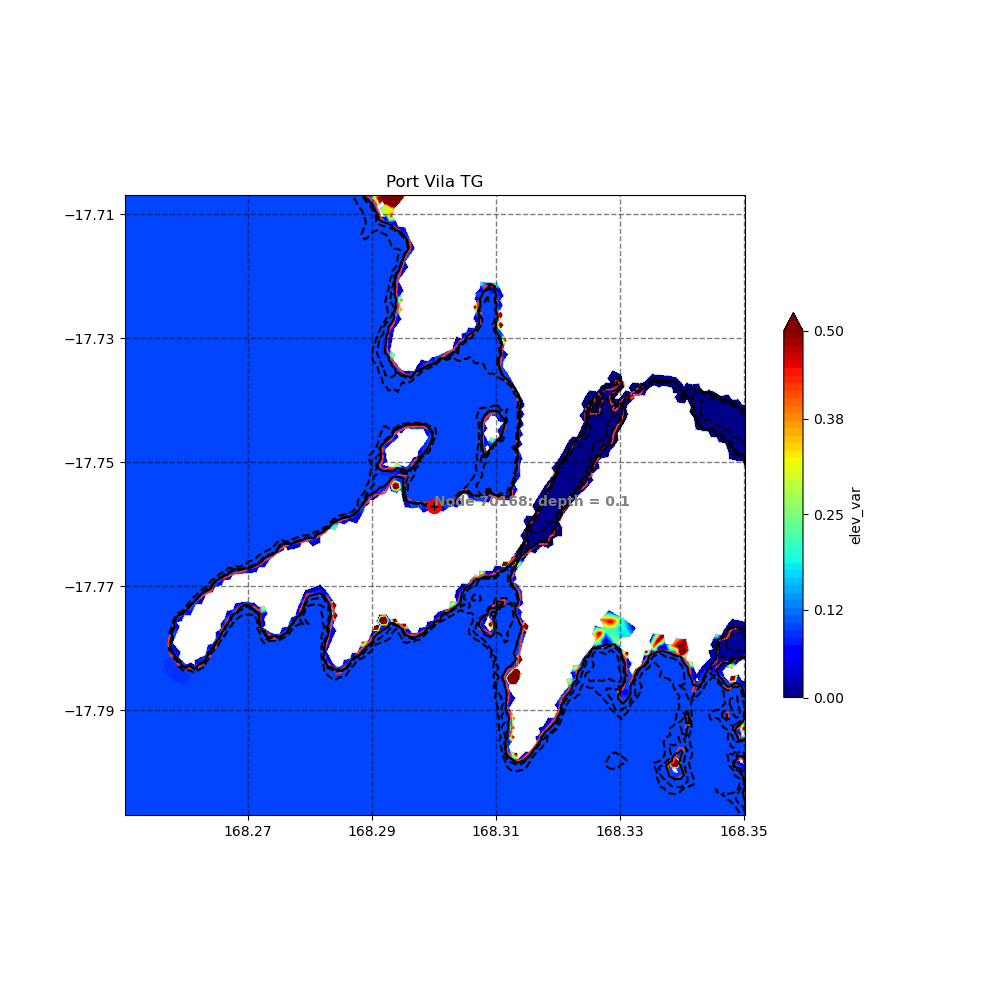

In [48]:
bbox = [TG_ds.attrs['lon']-0.05, TG_ds.attrs['lat']-0.05,
        TG_ds.attrs['lon']+0.05, TG_ds.attrs['lat']+0.05]


fig, ax = schism_plot(schout_ds, meshtri,'elev_var', varscale=[0,0.5], 
                      bbox = bbox, pscale=10,project=True,plotmesh=True,
                      contours=[0,1,5])
# depth_data = EOMap_bathy_ds.isel(x=slice(

ax.set_title('Port Vila TG')
ax.add_feature(shoreline_feature)

idxs = kdtree_find2Didx(x,y,[TG_ds.attrs['lon'], TG_ds.attrs['lat']])
pdata = schout_ds.isel(nSCHISM_hgrid_node=idxs)
ax.plot(pdata.SCHISM_hgrid_node_x,pdata.SCHISM_hgrid_node_y, 'ro',markersize=10)
ax.plot(pdata.SCHISM_hgrid_node_x,pdata.SCHISM_hgrid_node_y, 'k+')
ax.text(pdata.SCHISM_hgrid_node_x,pdata.SCHISM_hgrid_node_y, f'Node {idxs}: depth = {pdata.depth.values:.1f}',fontweight='bold',color='gray')

## Time series plots 
# fig, axs = plt.subplots(ncols=1, figsize=(12, 6))
# pdata.elev.plot.line(x='time',ax=axs)
# pdata.hs.plot.line(x='time',ax=axs[1])
# pdata.WWM_1.plot.line(x='time',ax=axs[1])

In [37]:
%matplotlib ipympl

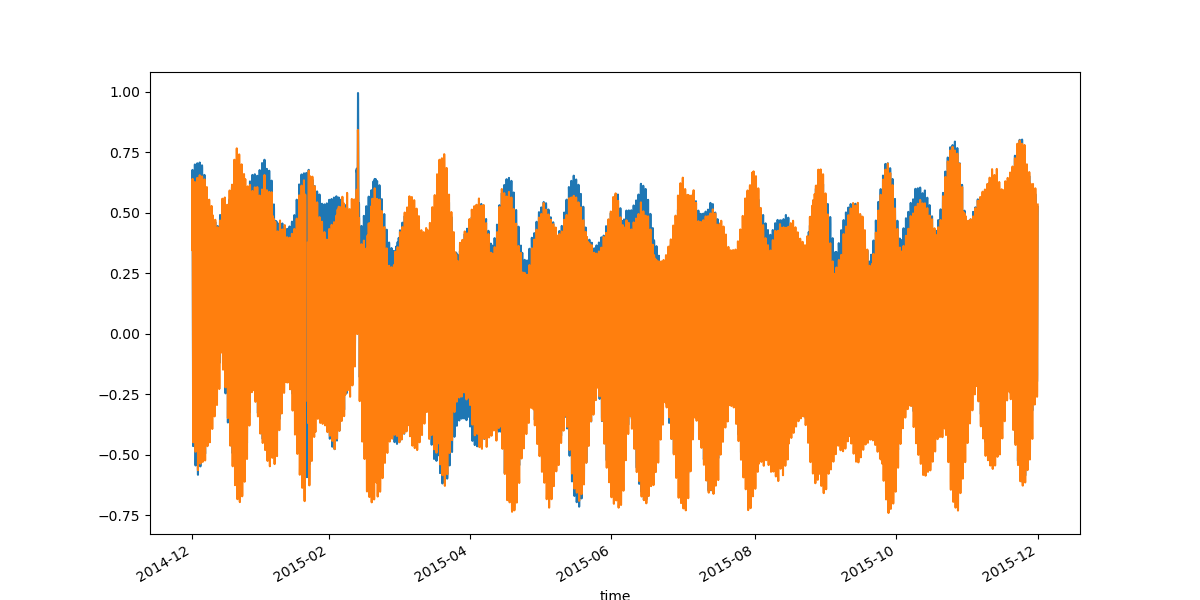

In [38]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 6))
pdata.elev.plot.line(x='time',ax=axs)
eta = TG_ds.sea_level.sel(time=slice(pdata.time[0],pdata.time[-1]))
eta = eta+(pdata.elev.mean('time')-TG_ds.sea_level.mean('time'))
eta.plot(ax=axs)

In [39]:
from tidegauge_processing_functions import calc_tides

In [40]:
pdata.attrs['lat']=TG_ds.attrs['lat']
# pdata['tide'] = add_tide_residules(pdata,atts4nc=False, time_name='time', eta_name = 'elev')

In [41]:
tide, coef = calc_tides(pdata['time'], pdata['elev'], pdata.attrs['lat']) 

solve: matrix prep ... solution ... done.
prep/calcs ... done.


In [42]:
pdata['tide'] = ('time',tide.h)

solve: matrix prep ... solution ... done.
prep/calcs ... done.


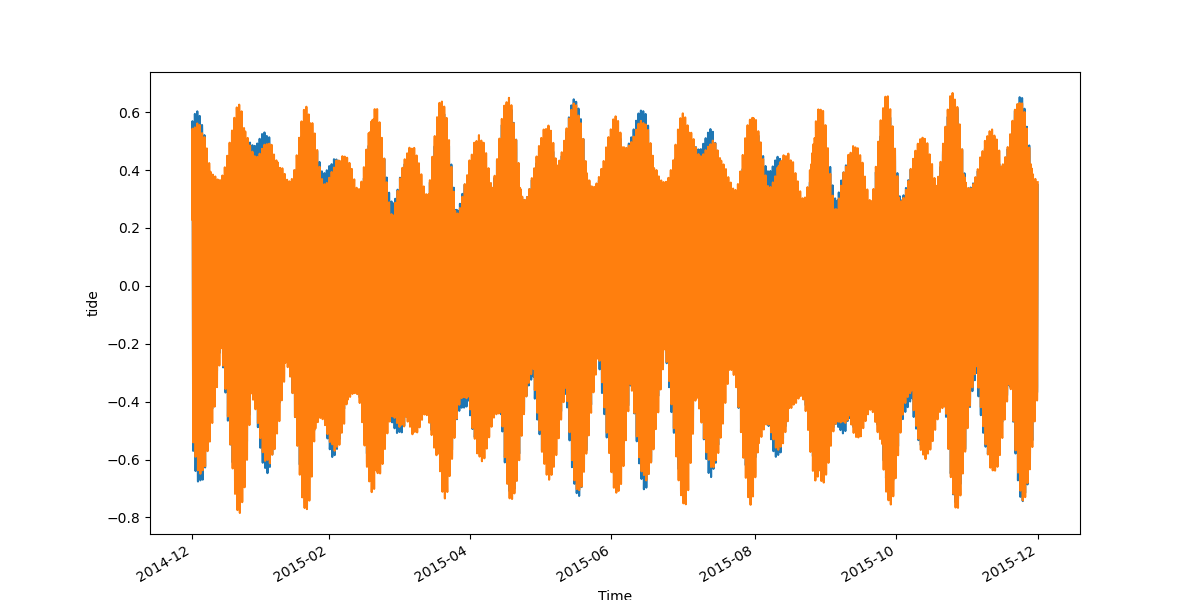

In [43]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 6))
pdata.tide.plot.line(x='time',ax=axs)
tide, coef = calc_tides(eta['time'], eta, pdata.attrs['lat']) 
axs.plot(eta['time'], tide.h)

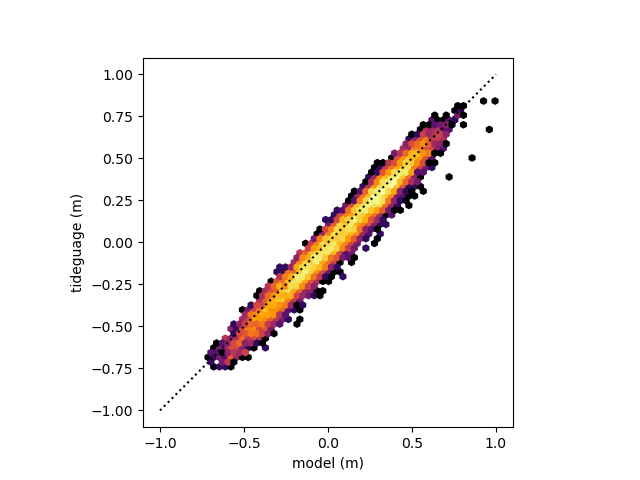

In [44]:
fig,ax=plt.subplots(1)
hb = ax.hexbin(pdata.elev, eta, gridsize=50, bins='log', cmap='inferno')
ax.plot([-1,1],[-1,1],':k')

ax.set_xlabel('model (m)')
ax.set_ylabel('tideguage (m)')
ax.set_aspect('equal')

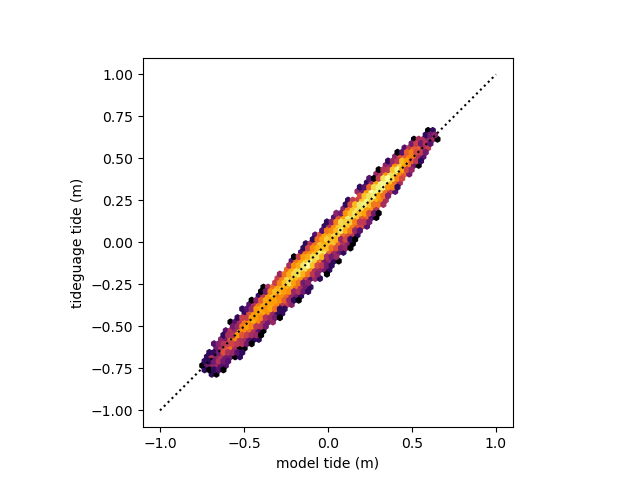

In [45]:
fig,ax=plt.subplots(1)
hb = ax.hexbin(pdata.tide, tide.h, gridsize=50, bins='log', cmap='inferno')
ax.plot([-1,1],[-1,1],':k')

ax.set_xlabel('model tide (m)')
ax.set_ylabel('tideguage tide (m)')
ax.set_aspect('equal')